# PCA + OLS estimation: DFM
---

> A partir dos componentes principais, que são os estimadores dos fatores, extraídos no script 'dfm_pca.ipynb', podemos estimar o primeiro modelo por MQO, em uma regressão do PIB em k fatores.

## Bibliotecas

In [35]:
import pandas as pd
import numpy as np
import datetime as dt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

## Carregando os dados 

In [3]:
# Carregando dados tratados e separando a variável-alvo: o PIB

data = pd.read_csv('../../data/data_tf.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data.set_index('Date', inplace = True)
gdp = data['gdp']
qgdp = (gdp.groupby(pd.PeriodIndex(gdp.index, freq = 'Q'), axis = 0)).mean()
qgdp

Date
2002Q1         NaN
2002Q2    0.043207
2002Q3    0.035439
2002Q4   -0.002176
2003Q1   -0.047467
            ...   
2021Q3    0.025785
2021Q4   -0.004322
2022Q1   -0.002627
2022Q2    0.017867
2022Q3    0.024755
Freq: Q-DEC, Name: gdp, Length: 83, dtype: float64

In [4]:
# Carregando os dados tranformados com PCA

data_pca = pd.read_csv('../../data/data_tfpca.csv')
# data['Date'] = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC') --> se fosse para trimestre 
data['Date'] = pd.date_range(start = '2002-01-01', end = '2022-09-01', freq = 'MS')
data_pca.set_index('Date', inplace = True)
data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")

# Selecionando base de dados com apenas 10 fatores, que explicam 94,7% da variação total do conjunto de variáveis explicativas

data_pca = data_pca[['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10']]
data_pca

C:\Users\HENRI\AppData\Local\Temp\ipykernel_2976\1822988027.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  data_pca.columns = data_pca.columns.str.replace(r"[C]", "F")


,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
Date,,,,,,,,,,
2002-01-01,0.043761,-0.301327,0.281876,-0.469964,-0.480213,0.267495,4.052348,-1.266854,1.604325,-0.029623
2002-02-01,-1.349206,-0.550805,0.872002,1.933582,-1.591338,2.024872,3.075690,-1.082151,1.912396,0.327998
2002-03-01,2.921580,2.328693,0.027064,0.010019,0.273320,-0.980296,3.500098,-1.881021,0.807566,-0.224126
2002-04-01,0.364593,1.489715,1.174915,0.080800,0.057597,0.565341,2.975339,-0.501164,2.160204,0.724248
2002-05-01,-0.021967,-0.240064,-0.508700,0.346847,-1.195284,0.596571,2.105202,-1.360489,1.832412,-2.509840
...,...,...,...,...,...,...,...,...,...,...
2022-05-01,5.656367,3.587253,-2.324899,-1.407377,-1.077000,-0.319084,0.803622,1.423434,0.346798,-5.502160
2022-06-01,-1.250367,-1.734443,0.124854,-0.019953,-3.158825,-2.717110,1.054606,4.052564,-4.752051,-3.012939
2022-07-01,1.715190,1.555140,-1.784176,3.606715,4.031505,-0.911592,-1.827816,-1.529660,2.326015,1.587895


## Preparando as variáveis

In [5]:
# Agrupando os fatores pela média para ficar na mesma frequência do PIB e preenchendo a primeira observação do PIB com a mediana 

qdata_pca = (data_pca.groupby(pd.PeriodIndex(data_pca.index, freq = 'Q'), axis = 0)).mean()
# qdata_pca.to_csv('../../data/qdata_tfpca.csv')
new_data = pd.merge(qgdp, qdata_pca, how='inner', left_index=True, right_index=True)
new_data.gdp.fillna(new_data.gdp.median(), inplace = True)
new_data['gdp'] = new_data['gdp'] * 100
new_data.index = pd.date_range(start = '2002-03-01', end = '2022-09-01', freq = 'QS-DEC')
new_data

,gdp,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411,0.437357,3.542712,-1.410008,1.441429,0.024750
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521,0.555046,2.055331,-1.683349,2.263962,-1.414056
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402,1.708108,2.452098,0.985706,2.723189,-2.060487
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546,1.241341,2.347363,-0.177495,3.033051,-1.434443
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151,0.577081,4.299099,-1.396467,0.792031,0.023317
...,...,...,...,...,...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580,-0.136194,-1.399026,1.282804,-0.357813,0.517160
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121,-0.989648,-1.303261,1.347845,1.466352,1.267444
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385,1.439377,-0.281474,0.233960,-3.768976,2.572942
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521,-0.829394,0.277045,2.288487,-4.953368,-2.686125


In [84]:
# Criando defasagens dos fatores

# Lags Fator 1
new_data['F1_1'] = new_data['F1'].shift(1)
new_data['F1_2'] = new_data['F1'].shift(2)
new_data['F1_4'] = new_data['F1'].shift(4)
new_data['F1_8'] = new_data['F1'].shift(8)


# Lags Fator 2
new_data['F2_1'] = new_data['F2'].shift(1)
new_data['F2_2'] = new_data['F2'].shift(2)
new_data['F2_3'] = new_data['F2'].shift(3)
new_data['F2_4'] = new_data['F2'].shift(4)
new_data['F2_5'] = new_data['F2'].shift(5)
new_data['F2_8'] = new_data['F2'].shift(8)
new_data['F2_12'] = new_data['F2'].shift(12)

# Lags Fator 3

new_data['F3_1'] = new_data['F3'].shift(1)
new_data['F3_2'] = new_data['F3'].shift(2)
new_data['F3_3'] = new_data['F3'].shift(3)
new_data['F3_4'] = new_data['F3'].shift(4)


#Lags Fator 4

new_data['F4_1'] = new_data['F4'].shift(1)
new_data['F4_2'] = new_data['F4'].shift(2)
new_data['F4_3'] = new_data['F4'].shift(3)
new_data['F4_4'] = new_data['F4'].shift(4)

# Lags Fator 5

new_data['F5_1'] = new_data['F5'].shift(1)
new_data['F5_2'] = new_data['F5'].shift(2)

# Lags GDP

new_data['gdp_1'] = new_data['gdp'].shift(1)
new_data['gdp_2'] = new_data['gdp'].shift(2)
new_data['gdp_4'] = new_data['gdp'].shift(4)
new_data['gdp_6'] = new_data['gdp'].shift(6)

In [85]:
new_data_5fac = new_data[['gdp', 'F1', 'F2', 'F3', 'F4', 'F5']].copy()
new_data_5fac

,gdp,F1,F2,F3,F4,F5
2002-03-01,0.388552,0.538712,0.492187,0.393648,0.491212,-0.599411
2002-06-01,4.320709,-0.442968,-0.049328,-0.098923,0.011377,-0.766521
2002-09-01,3.543887,0.424707,-0.647956,0.217876,-4.446846,-1.604402
2002-12-01,-0.217573,-0.232993,-2.268012,6.315600,-11.643441,-3.549546
2003-03-01,-4.746729,-1.958564,0.865307,3.212400,-5.975119,-1.915151
...,...,...,...,...,...,...
2021-09-01,2.578462,-0.342376,0.778500,2.328568,-1.987400,-0.206580
2021-12-01,-0.432211,1.693068,-3.285857,2.140440,-3.050982,1.034121
2022-03-01,-0.262737,-2.583732,2.756302,0.194961,-5.354888,-1.059385
2022-06-01,1.786737,-0.366600,-0.601419,0.377088,-1.336048,-1.747521


In [86]:
# train and test dates

train_start_date = "2002-03-01"
train_end_date = "2017-12-01"
test_start_date = "2018-03-01"
test_end_date = "2022-09-01"

# train and test datasets

train = new_data.loc[(new_data.index >= train_start_date) & (new_data.index <= train_end_date), :]
test = new_data.loc[(new_data.index >= test_start_date) & (new_data.index <= test_end_date), :]

In [87]:
# Train dataset

X_train = train.drop('gdp', axis = 1)
y_train = train['gdp']

# Test dataset 

X_test = test.drop('gdp', axis = 1)
y_test = test['gdp']

# Modelos
---

## 1. DFM: regressão linear por MQO - 5 fatores utilizados

In [41]:
X5_train = X_train[['F1', 'F2', 'F3', 'F4', 'F5']].copy()
X5_test = X_test[['F1', 'F2', 'F3', 'F4', 'F5']].copy()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = train)
dfm_ols_5fac = reg.fit()
print(dfm_ols_5fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.489
Method:                 Least Squares   F-statistic:                     13.04
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           1.63e-08
Time:                        09:35:09   Log-Likelihood:                -129.41
No. Observations:                  64   AIC:                             270.8
Df Residuals:                      58   BIC:                             283.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5255      0.247      2.129      0.0

In [45]:
# Teste de Breusch-Godfray para autocorrelação dos erros

bg_result = acorr_breusch_godfrey(dfm_ols_5fac, nlags = 4)
lagrpval = bg_result[1]
fpval = bg_result[3]
print(f'lagrpval: {round(lagrpval, 4)}\n')
print(f'fpval: {round(fpval, 4)}\n')

lagrpval: 0.0001

fpval: 0.0



> Rejeitamos a hipótese nula de que não há correlação dos resíduos em t com 4 defasagens. Ou seja, há autocorrelação nos resíduos. 

## 2. DFM: regressão linear MQO - 1 fator

In [43]:
reg = smf.ols('gdp ~ F1', data = train)
dfm_ols_1fac = reg.fit()
print(dfm_ols_1fac.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     12.32
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           0.000841
Time:                        09:38:36   Log-Likelihood:                -147.72
No. Observations:                  64   AIC:                             299.4
Df Residuals:                      62   BIC:                             303.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6504      0.309      2.104      0.0

In [46]:
# Teste de Breusch-Godfray para autocorrelação dos erros

bg_result = acorr_breusch_godfrey(dfm_ols_1fac, nlags = 4)
lagrpval = bg_result[1]
fpval = bg_result[3]
print(f'lagrpval: {round(lagrpval, 4)}\n')
print(f'fpval: {round(fpval, 4)}\n')

lagrpval: 0.0

fpval: 0.0



> Rejeitamos a hipótese nula de que não há correlação dos resíduos em t com 4 defasagens. Ou seja, há autocorrelação nos resíduos. 

## 3. DFM: um fator e uma defasagem do fator

In [49]:
reg = smf.ols('gdp ~ F1 + F1_1', data = train)
dfm_ols_1fac_1lag = reg.fit()
print(dfm_ols_1fac_1lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     13.09
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           1.92e-05
Time:                        09:42:33   Log-Likelihood:                -140.21
No. Observations:                  63   AIC:                             286.4
Df Residuals:                      60   BIC:                             292.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6795      0.289      2.348      0.0

In [50]:
# Teste de Breusch-Godfray para autocorrelação dos erros

bg_result = acorr_breusch_godfrey(dfm_ols_1fac_1lag, nlags = 4)
lagrpval = bg_result[1]
fpval = bg_result[3]
print(f'lagrpval: {round(lagrpval, 4)}\n')
print(f'fpval: {round(fpval, 4)}\n')

lagrpval: 0.0

fpval: 0.0



> Rejeitamos a hipótese nula de que não há correlação dos resíduos em t com 4 defasagens. Ou seja, há autocorrelação nos resíduos. 

## 4. DFM: 3 fatores e uma lag para o segundo e o terceiro fator mais uma defasagem do PIB a 2 trimestres anteriores

In [115]:
reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1', data = train)
dfm_ols_3fac_5lag = reg.fit()
print(dfm_ols_3fac_5lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     61.88
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           1.45e-23
Time:                        10:26:23   Log-Likelihood:                -73.193
No. Observations:                  60   AIC:                             164.4
Df Residuals:                      51   BIC:                             183.2
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4833      0.144      3.353      0.0

In [116]:
# Teste de Breusch-Godfray para autocorrelação dos erros

bg_result = acorr_breusch_godfrey(dfm_ols_3fac_5lag, nlags = 4)
lagrpval = bg_result[1]
fpval = bg_result[3]
print(f'lagrpval: {round(lagrpval, 4)}\n')
print(f'fpval: {round(fpval, 4)}\n')

lagrpval: 0.0019

fpval: 0.003



In [117]:
train['resid4'] = dfm_ols_3fac_5lag.resid
train['resid4_1'] = train['resid4'].shift(1)

X_train['resid4'] = dfm_ols_3fac_5lag.resid
X_train['resid4_1'] = train['resid4'].shift(1)

C:\Users\HENRI\AppData\Local\Temp\ipykernel_2976\192425561.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['resid4'] = dfm_ols_3fac_5lag.resid
C:\Users\HENRI\AppData\Local\Temp\ipykernel_2976\192425561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['resid4_1'] = train['resid4'].shift(1)


In [118]:
reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1 + resid4_1', data = train)
dfm_ols_3fac_5lag = reg.fit()
print(dfm_ols_3fac_5lag.summary())

                            OLS Regression Results                            
Dep. Variable:                    gdp   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     66.48
Date:                Mon, 26 Dec 2022   Prob (F-statistic):           2.25e-24
Time:                        10:26:27   Log-Likelihood:                -64.217
No. Observations:                  59   AIC:                             148.4
Df Residuals:                      49   BIC:                             169.2
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5618      0.129      4.341      0.0

In [108]:
# Teste de Breusch-Godfray para autocorrelação dos erros

bg_result = acorr_breusch_godfrey(dfm_ols_3fac_5lag, nlags = 4)
lagrpval = bg_result[1]
fpval = bg_result[3]
print(f'lagrpval: {round(lagrpval, 4)}\n')
print(f'fpval: {round(fpval, 4)}\n')

lagrpval: 0.1279

fpval: 0.2034



## Sumários das regressões 

In [14]:
stargazer = Stargazer([dfm_ols_1fac, dfm_ols_5fac])
stargazer.custom_columns(['1 Factor Model', '5 Factor Model'], [1, 1])
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
\begin{tabular}{@{\extracolsep{5pt}}lcc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{2}{c}{\textit{Dependent variable:}} \
\cr \cline{2-3}
\\[-1.8ex] & \multicolumn{1}{c}{1 Factor Model} & \multicolumn{1}{c}{5 Factor Model}  \\
\\[-1.8ex] & (1) & (2) \\
\hline \\[-1.8ex]
 F1 & 0.627$^{***}$ & 1.394$^{***}$ \\
  & (0.179) & (0.238) \\
 F2 & & 0.331$^{***}$ \\
  & & (0.119) \\
 F3 & & -0.197$^{*}$ \\
  & & (0.108) \\
 F4 & & 0.295$^{**}$ \\
  & & (0.117) \\
 F5 & & -1.140$^{***}$ \\
  & & (0.231) \\
 Intercept & 0.650$^{**}$ & 0.526$^{**}$ \\
  & (0.309) & (0.247) \\
\hline \\[-1.8ex]
 Observations & 64 & 64 \\
 $R^2$ & 0.166 & 0.529 \\
 Adjusted $R^2$ & 0.152 & 0.489 \\
 Residual Std. Error & 2.472(df = 62) & 1.920(df = 58)  \\
 F Statistic & 12.321$^{***}$ (df = 1.0; 62.0) & 13.041$^{***}$ (df = 5.0; 58.0) \\
\hline
\hline \\[-1.8ex]
\textit{Note:} & \multicolumn{2}{r}{$^{*}$p$<$0.1; $^{**}$p$<$0.05; $^{***}$p$<$0.01} \\
\end{tabular}
\end{table}


# Previsões: DFM não atualizado

## Dentro da amostra

<AxesSubplot: >

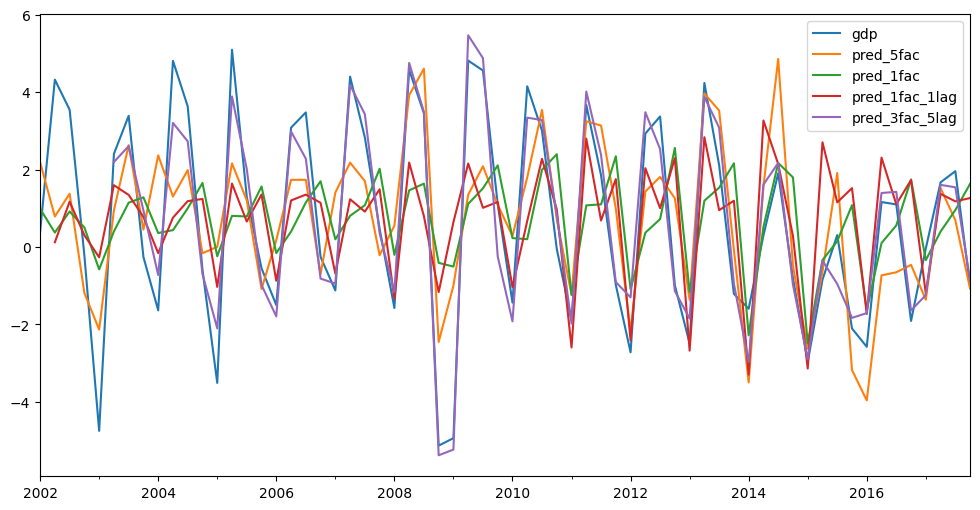

In [119]:
forecasts_insample = pd.DataFrame()
forecasts_insample['gdp'] = y_train
forecasts_insample['pred_5fac'] = dfm_ols_5fac.predict(X_train[['F1', 'F2', 'F3', 'F4', 'F5']])
forecasts_insample['pred_1fac'] = dfm_ols_1fac.predict(X_train['F1'])
forecasts_insample['pred_1fac_1lag'] = dfm_ols_1fac_1lag.predict(X_train[['F1', 'F1_1']])
forecasts_insample['pred_3fac_5lag'] = dfm_ols_3fac_5lag.predict(X_train[['gdp_2', 'gdp_4', 'F1', 'F1_4', 'F2', 'F2_1', 'F3', 'F3_1', 'resid4_1']])
forecasts_insample.plot(figsize = (12,6))
# plt.savefig('dfm-images-plots/forecast_1and5_factors_insample.png')

### Métricas de previsão: dentro da amostra

In [120]:
rmse_insample_5fac = np.sqrt(((dfm_ols_5fac.predict(X5_train) - y_train) ** 2).mean())
mae_insample_5fac = ((dfm_ols_5fac.predict(X5_train) - y_train).abs()).mean()
print(rmse_insample_5fac, mae_insample_5fac, sep = '\n\n')

1.827842929311588

1.5208702710661632


In [121]:
rmse_insample_1fac = np.sqrt(((dfm_ols_1fac.predict(X5_train.F1) - y_train) ** 2).mean())
mae_insample_1fac = ((dfm_ols_1fac.predict(X5_train.F1) - y_train).abs()).mean()
print(rmse_insample_1fac, mae_insample_1fac, sep = '\n\n')

2.433237180665312

2.087072438552906


In [122]:
rmse_insample_1fac_1lag = np.sqrt(((forecasts_insample['pred_1fac_1lag'] - forecasts_insample['gdp']) ** 2).mean())
mae_insample_1fac_1lag = ((forecasts_insample['pred_1fac_1lag'] - forecasts_insample['gdp']).abs()).mean()
print(rmse_insample_1fac_1lag, mae_insample_1fac_1lag, sep = '\n\n')

2.2403418336799192

1.8222082860663942


In [124]:
rmse_insample_3fac_1lag = np.sqrt(((forecasts_insample['pred_3fac_5lag'] - forecasts_insample['gdp']) ** 2).mean())
mae_insample_3fac_1lag = ((forecasts_insample['pred_3fac_5lag'] - forecasts_insample['gdp']).abs()).mean()
print(rmse_insample_3fac_1lag, mae_insample_3fac_1lag, sep = '\n\n')

0.7185479630181884

0.5705001066469892


## Fora da amostra

> Esse tipo de previsão com um modelo para prever t+1, t+2, t+3 começa a perder validade com o avanço do tempo. O certo é recalibrar os modelos para prever sempre um passo a frente, t+1, para comparar com In-sample. 

In [20]:
'''forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_5fac'] = dfm_ols_5fac.predict(X5_test)
forecasts_outsample['pred_1fac'] = dfm_ols_1fac.predict(X5_test.F1)
forecasts_outsample.plot(figsize=(12,6))'''

"forecasts_outsample = pd.DataFrame()\nforecasts_outsample['gdp'] = y_test\nforecasts_outsample['pred_5fac'] = dfm_ols_5fac.predict(X5_test)\nforecasts_outsample['pred_1fac'] = dfm_ols_1fac.predict(X5_test.F1)\nforecasts_outsample.plot(figsize=(12,6))"

### Métricas de previsão: fora da amostra

In [21]:
'''rmse_outsample_5fac = np.sqrt(((dfm_ols_5fac.predict(X5_test) - y_test) ** 2).mean())
mae_outsample_5fac = ((dfm_ols_5fac.predict(X5_test) - y_test).abs()).mean()
print(rmse_outsample_5fac, mae_outsample_5fac, sep = '\n\n')'''

"rmse_outsample_5fac = np.sqrt(((dfm_ols_5fac.predict(X5_test) - y_test) ** 2).mean())\nmae_outsample_5fac = ((dfm_ols_5fac.predict(X5_test) - y_test).abs()).mean()\nprint(rmse_outsample_5fac, mae_outsample_5fac, sep = '\n\n')"

In [22]:
'''rmse_outsample_1fac = np.sqrt((( dfm_ols_1fac.predict(X5_test.F1) - y_test) ** 2).mean())
mae_outsample_1fac = ((dfm_ols_1fac.predict(X5_test.F1) - y_test).abs()).mean()
print(rmse_outsample_1fac, mae_outsample_1fac, sep = '\n\n')'''

"rmse_outsample_1fac = np.sqrt((( dfm_ols_1fac.predict(X5_test.F1) - y_test) ** 2).mean())\nmae_outsample_1fac = ((dfm_ols_1fac.predict(X5_test.F1) - y_test).abs()).mean()\nprint(rmse_outsample_1fac, mae_outsample_1fac, sep = '\n\n')"

# Previsões: DFM atualizado

Usando um loop para reestimar e computar as novas previsões

## 5 fatores

In [23]:
test_5fac = test[['F1', 'F2', 'F3', 'F4', 'F5']].copy()
list_5fac = list()

reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':'2017Q4',])
dfm_5fac = reg.fit()
pred = dfm_5fac.predict(test_5fac.loc['2018Q1']).values[0]
list_5fac.append(pred)

for i, j in zip(test_5fac.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F2 + F3 + F4 + F5', data = new_data.loc['2002Q1':i,])
    dfm_5fac = reg.fit()
    pred = dfm_5fac.predict(test_5fac.loc[j]).values[0]
    list_5fac.append(pred)

list_5fac

[-0.46919795405136316,
 2.74864684895456,
 0.5989023312090751,
 -1.8483330821643182,
 -1.977878965583903,
 2.2482716178087596,
 2.8689281558475916,
 -2.6354647692750093,
 -0.5278429573915773,
 0.24228208651476912,
 1.3959859191820165,
 -0.5179942431580921,
 -0.05812409476262381,
 0.5341087383939507,
 0.4144508154150295,
 0.3831980308614621,
 -1.3313868614543125,
 0.8305971406778356,
 1.7858433084479726]

## 1 fator

In [24]:
test_1fac = test[['F1']].copy()
list_1fac = list()

reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_1fac = reg.fit()
pred = dfm_1fac.predict(test_1fac.loc['2018Q1']).values[0]
list_1fac.append(pred)

for i, j in zip(test_1fac.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1', data = new_data.loc['2002Q1':i,])
    dfm_1fac = reg.fit()
    pred = dfm_1fac.predict(test_1fac.loc[j]).values[0]
    list_1fac.append(pred)

list_1fac

[-0.22511040983436714,
 0.4005661807538234,
 0.7457942889564265,
 1.538487097529694,
 -0.848911905731383,
 0.6780245190446317,
 1.5310301054433642,
 1.4159129248763256,
 -1.734814816310719,
 0.11742319870716672,
 2.4265091542848554,
 1.708499605250144,
 -1.47902998710919,
 0.6896171449922639,
 0.35110497785383715,
 1.8947610837029154,
 -1.2743738885487255,
 0.3557678171378729,
 1.4597835575410192]

## 1 fator, 1 lag

In [25]:
test_1fac_1lag = test[['F1', 'F1_1']].copy()
list_1fac_1lag = list()

reg = smf.ols('gdp ~ F1 + F1_1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_1fac_1lag = reg.fit()
pred = dfm_1fac_1lag.predict(test_1fac_1lag.loc['2018Q1']).values[0]
list_1fac_1lag.append(pred)

for i, j in zip(test_1fac_1lag.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ F1 + F1_1', data = new_data.loc['2002Q1':i,])
    dfm_1fac_1lag = reg.fit()
    pred = dfm_1fac_1lag.predict(test_1fac_1lag.loc[j]).values[0]
    list_1fac_1lag.append(pred)

list_1fac_1lag

[-0.9974208187164652,
 1.2784450853980482,
 0.9848086859843057,
 1.3740545448907948,
 -1.4255759016194878,
 2.135219509493714,
 1.3783303497547266,
 0.4980801905669312,
 -2.112855529793632,
 2.5134010129674316,
 2.5809464793234125,
 0.47596732064024816,
 -1.8888161123189988,
 1.7109064194028176,
 0.3383515346397971,
 1.9470613375882548,
 -1.7397326572940592,
 1.2756192313167767,
 1.5338355609656904]

# 3 fatores, 2 defasagens do PIB (t-2 e t-4), 1 defasagem do F1 (t-4), 1 defasagem do F2 (t-1) e uma defasagem do F3 (t-1)

In [ ]:
test_3fac_5lag = test[['gdp_2', 'gdp_4', 'F1', 'F1_4', 'F2', 'F2_1', 'F3', 'F3_1']].copy()
list_3fac_5lag = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_3fac_1lag = reg.fit()
pred = dfm_3fac_1lag.predict(test_3fac_5lag.loc['2018Q1']).values[0]
list_3fac_5lag.append(pred)

for i, j in zip(test_3fac_5lag.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1', data = new_data.loc['2002Q1':i,])
    dfm_3fac_1lag = reg.fit()
    pred = dfm_3fac_1lag.predict(test_3fac_5lag.loc[j]).values[0]
    list_3fac_5lag.append(pred)

list_3fac_5lag

In [26]:
test_3fac_5lag = test[['gdp_2', 'gdp_4', 'F1', 'F1_4', 'F2', 'F2_1', 'F3', 'F3_1']].copy()
list_3fac_5lag = list()

reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1', data = new_data.loc['2002Q1':'2017Q4',])
dfm_3fac_1lag = reg.fit()
pred = dfm_3fac_1lag.predict(test_3fac_5lag.loc['2018Q1']).values[0]
list_3fac_5lag.append(pred)

for i, j in zip(test_3fac_5lag.index, new_data.loc['2018Q2':,].index):
    reg = smf.ols('gdp ~ gdp_2 + gdp_4 + F1 + F1_4 + F2 + F2_1 + F3 + F3_1', data = new_data.loc['2002Q1':i,])
    dfm_3fac_1lag = reg.fit()
    pred = dfm_3fac_1lag.predict(test_3fac_5lag.loc[j]).values[0]
    list_3fac_5lag.append(pred)

list_3fac_5lag

[-0.8413304184479569,
 2.017537195431828,
 1.4205965643198057,
 -1.1596379995860766,
 -1.3947103737648012,
 1.6093210056499956,
 2.184286616585514,
 -0.44860808912985184,
 -3.716277081113698,
 -5.011399515243159,
 8.914519030536784,
 5.498936382622844,
 -3.100360197383837,
 -3.670841076417795,
 5.05797179530181,
 -0.3898411276810454,
 -0.9839960246629694,
 1.0270678909594295,
 1.089280244286471]

## Dataframe e gráfico de previsões fora da amostra

<AxesSubplot: >

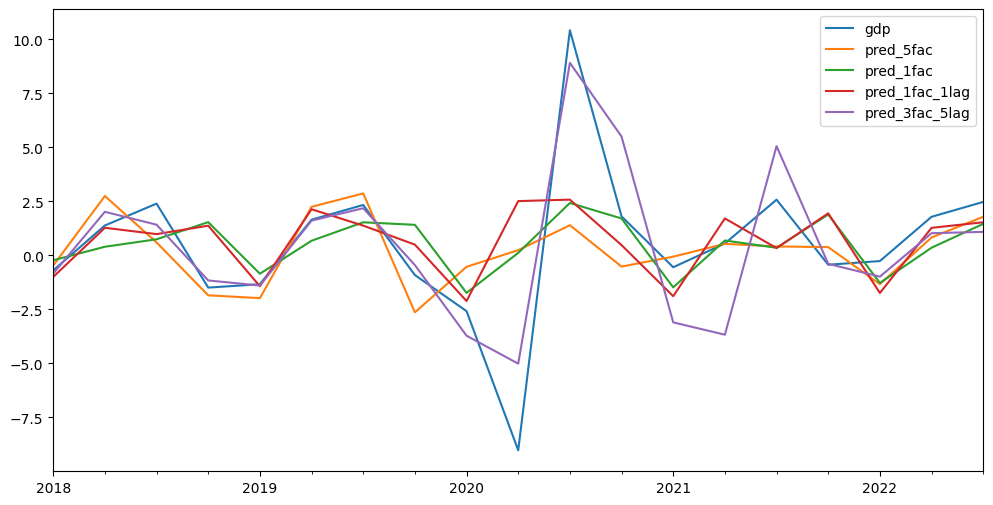

In [27]:
forecasts_outsample = pd.DataFrame()
forecasts_outsample['gdp'] = y_test
forecasts_outsample['pred_5fac'] = list_5fac
forecasts_outsample['pred_1fac'] = list_1fac
forecasts_outsample['pred_1fac_1lag'] = list_1fac_1lag
forecasts_outsample['pred_3fac_5lag'] = list_3fac_5lag
forecasts_outsample.plot(figsize = (12,6))
# plt.savefig('dfm-images-plots/forecast_1and5_factors_outsample.png')

## Métricas de precisão: fora da amostra

In [28]:
rmse_outsample_5fac = np.sqrt(((forecasts_outsample['pred_5fac'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_5fac = ((forecasts_outsample['pred_5fac'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_5fac, mae_outsample_5fac, sep = '\n')

3.1977164484578124
1.9005002265647193


In [29]:
rmse_outsample_1fac = np.sqrt(((forecasts_outsample['pred_1fac'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_1fac = ((forecasts_outsample['pred_1fac'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_1fac, mae_outsample_1fac, sep = '\n')

3.110558357815622
1.9938627254225636


In [30]:
rmse_outsample_1fac_1lag = np.sqrt(((forecasts_outsample['pred_1fac_1lag'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_1fac_1lag = ((forecasts_outsample['pred_1fac_1lag'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_1fac_1lag, mae_outsample_1fac_1lag, sep = '\n')

3.457048075371088
2.044160433788294


In [31]:
rmse_outsample_3fac_1lag = np.sqrt(((forecasts_outsample['pred_3fac_5lag'] - forecasts_outsample['gdp']) ** 2).mean())
mae_outsample_3fac_1lag = ((forecasts_outsample['pred_3fac_5lag'] - forecasts_outsample['gdp']).abs()).mean()
print(rmse_outsample_3fac_1lag, mae_outsample_3fac_1lag, sep = '\n')

1.8988883181296248
1.3319724853129862


# Análise dos resíduos das regressões
---

In [32]:
# Criando função para plotar as autocorrelações dos resíduos das regressões

def autocorr_plots(y1, y2, y3, y4, title1, title2, title3, title4):
    fig = plt.figure(figsize=(16,20))
    ax1 = fig.add_subplot(411) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a primeira posição
    fig = plot_acf(y1, ax = ax1, title = title1)
    ax2 = fig.add_subplot(412) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a segunda posição
    fig = plot_acf(y2, ax=ax2, title = title2)
    ax3 = fig.add_subplot(413) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a terceira posição
    fig = plot_acf(y3, ax = ax3, title = title3)
    ax4 = fig.add_subplot(414) # 3 linhas, uma para cada gráfico. Essa ocupara a primera coluna e a terceira posição
    fig = plot_acf(y4, ax = ax4, title = title4)

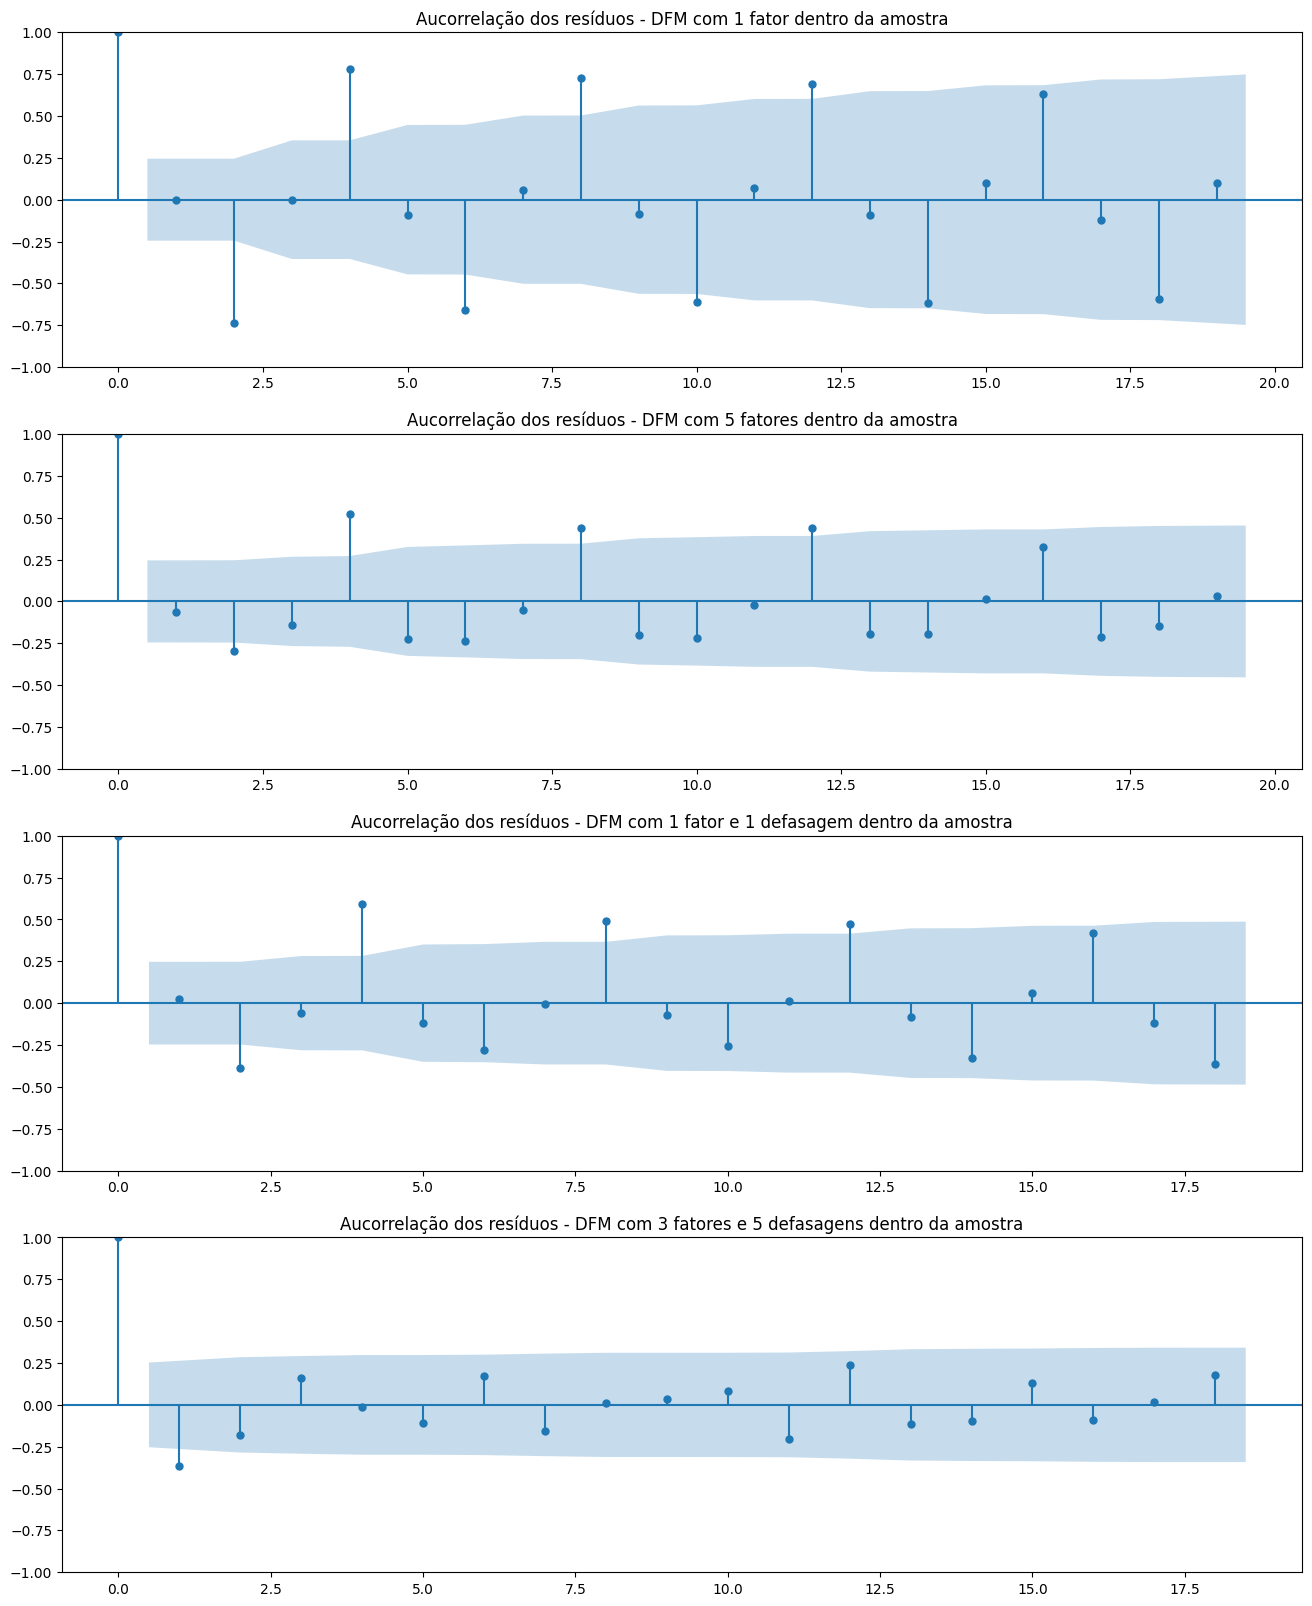

In [33]:
autocorr_plots(dfm_ols_1fac.resid, dfm_ols_5fac.resid, dfm_ols_1fac_1lag.resid, dfm_ols_3fac_5lag.resid,
               'Aucorrelação dos resíduos - DFM com 1 fator dentro da amostra',
               'Aucorrelação dos resíduos - DFM com 5 fatores dentro da amostra',
               'Aucorrelação dos resíduos - DFM com 1 fator e 1 defasagem dentro da amostra',
               'Aucorrelação dos resíduos - DFM com 3 fatores e 5 defasagens dentro da amostra')

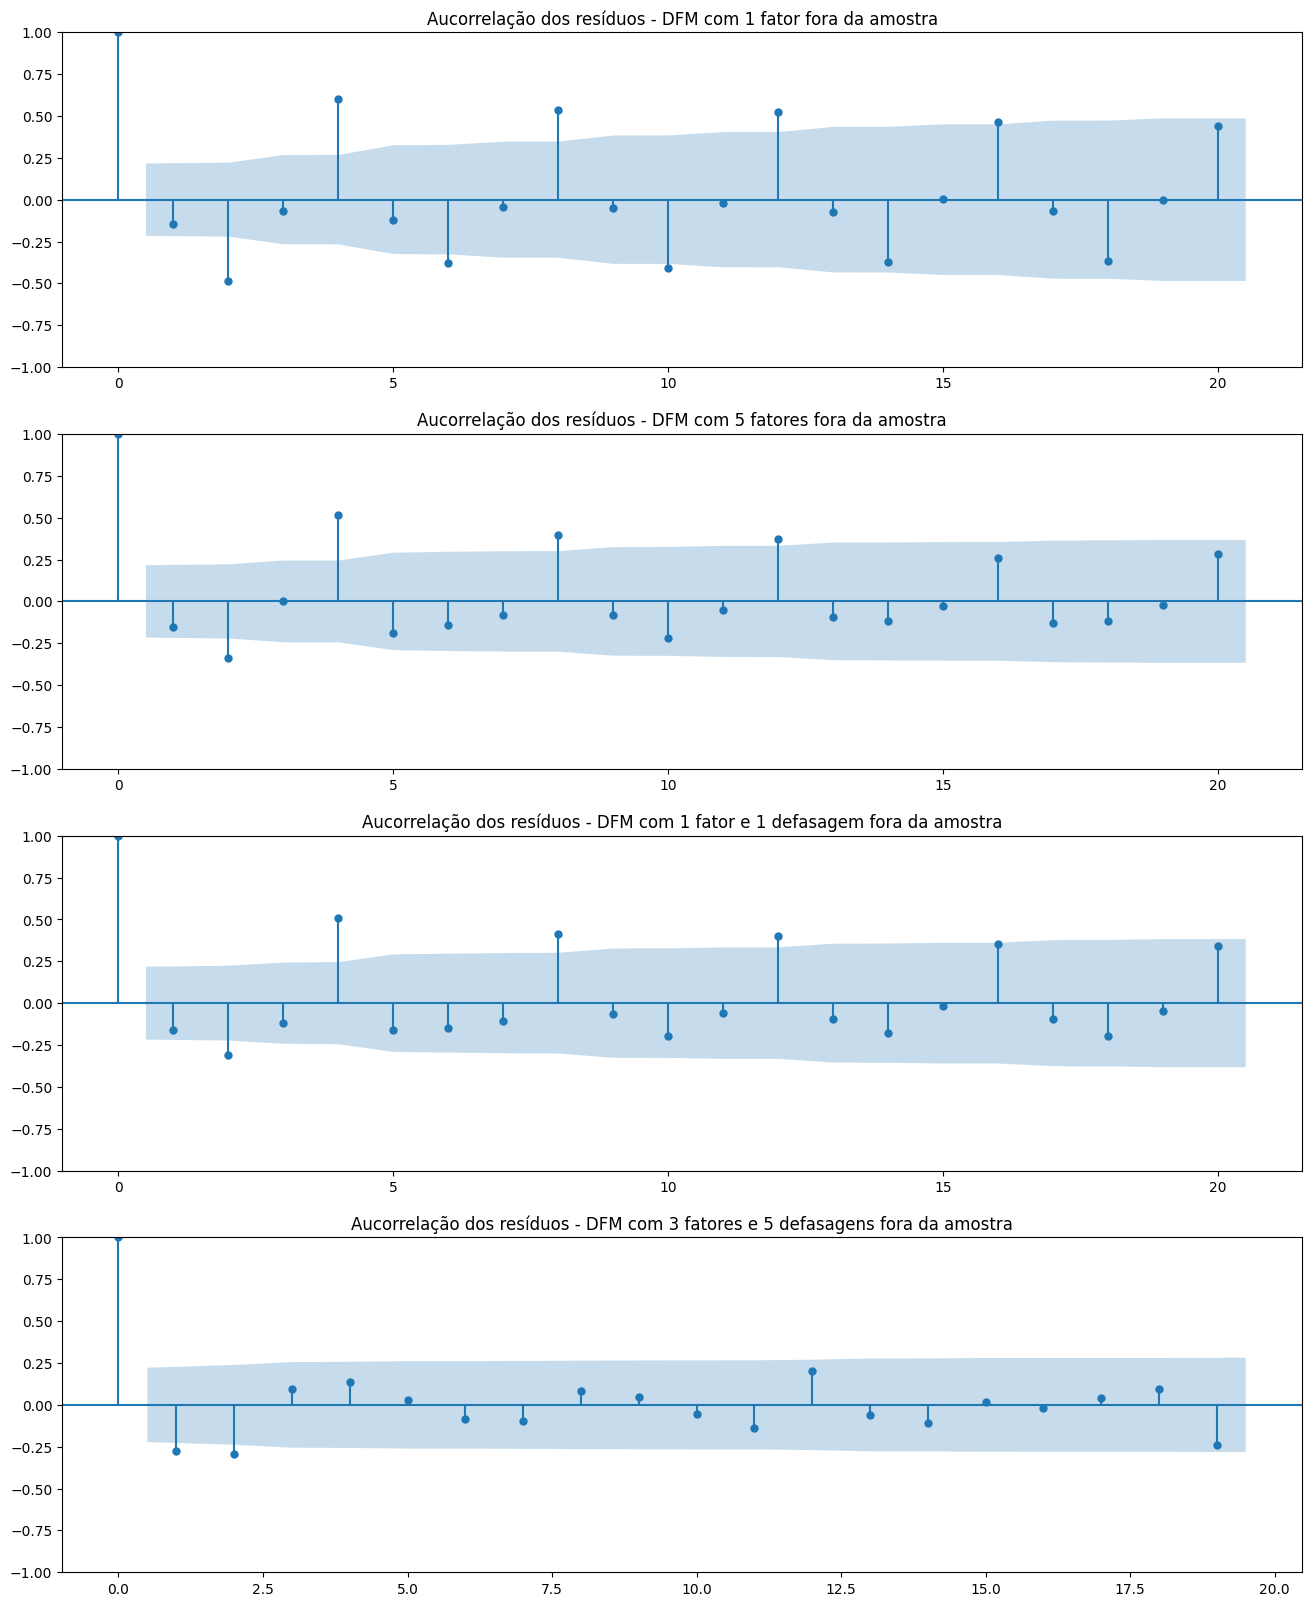

In [34]:
autocorr_plots(dfm_1fac.resid, dfm_5fac.resid, dfm_1fac_1lag.resid, dfm_3fac_1lag.resid,
               'Aucorrelação dos resíduos - DFM com 1 fator fora da amostra',
               'Aucorrelação dos resíduos - DFM com 5 fatores fora da amostra',
               'Aucorrelação dos resíduos - DFM com 1 fator e 1 defasagem fora da amostra',
               'Aucorrelação dos resíduos - DFM com 3 fatores e 5 defasagens fora da amostra')